In [1]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse
import random

from collections import Counter


from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
random_seed = 123
rng = np.random.default_rng(random_seed)

In [3]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

In [9]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

In [10]:
def bernoulli_loglike(X, θ, π):
    # Compute Categorical Distribution over components for each row using SoftMax
    logp  = np.log(π) + (X @ np.log(θ).T + (1 - X) @ np.log(1 - θ).T) # log likelihood
    logp -= logp.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(logp)
    p    /= p.sum(axis=1, keepdims=True) # normalize

    return p

In [41]:
def bernoulli_loglike(X, θ, π, M, missing_mask, mnar=False):
    N,D = X.shape
    K,_ = θ.shape 
    log_ps = np.zeros((N,K))
    obs_mask = ~missing_mask

    for i in range(N):
        r_i = obs_mask[i].astype(float)

        for k in range(K):
            x_obs = X[i][obs_mask[i]]
            θ_obs = θ[k][obs_mask[i]]

            log_ps[i,k] = (
                            np.log(π[k]) + 
                            np.sum(x_obs * np.log(θ_obs)) + np.sum((1 - x_obs) * np.log(1 - θ_obs)) 
                        )
            if mnar :
                log_ps[i,k] += np.sum(r_i * np.log(M[k])) + np.sum((1 - r_i)* np.log(1 - M[k]))

    log_ps -= log_ps.max(axis=1, keepdims=True) # reduce logits for numerical stability (invariance property)
    p     = np.exp(log_ps)
    p    /= p.sum(axis=1, keepdims=True) # normalize  

    return p


# 2 Un-Collapsed Gibbs Sampling

Joint Posterior 

$$\begin{align}
    p(\boldsymbol{\pi},\boldsymbol{\theta},\mathbf{z}|\mathbf{X},\boldsymbol{\alpha},a,b) \propto p(\mathbf{X}_H|\mathbf{z},\boldsymbol{\theta}) p(\mathbf{X}_O|\mathbf{z}, \boldsymbol{\theta})p(\mathbf{M}| \mathbf{z}, \boldsymbol{\gamma}) p(\mathbf{z}|\boldsymbol{\pi}) p(\boldsymbol{\pi}|\boldsymbol{\alpha}) p(\boldsymbol{\theta}|a,b)
\end{align}$$

Routine

1) Initialize 
$$\begin{align}
    \boldsymbol{\alpha} &= [\alpha_1 = \frac{1}{K},...,\alpha_K = \frac{1}{K}]\\
    a,b &= \frac{1}{2}\\
    \boldsymbol{\pi} &\sim \mathcal{Dirichlet}(\boldsymbol{\alpha}) \\
    \boldsymbol{\theta} &\sim \mathcal{Beta}(a,b)\\
    \boldsymbol{z} &\sim \mathcal{Cat}(\boldsymbol{\pi})
\end{align}$$



2) For $t=1,..,N$  

$$
\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim p(\boldsymbol{\pi} | \boldsymbol{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}) \\
        \boldsymbol{\alpha}_N^{(t-1)} &= \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample }\mathbf X^{(t)}
        &\sim p(\mathbf X\mid\mathbf z^{(t-1)},\boldsymbol{\theta}^{(t-1)}) \\
    \text{for } i &\in \{1,\dots,N\}: \;
        \mathbf x_{H,i}^{(t)}\sim\mathrm{Bernoulli}\bigl(\theta^{(t-1)}_{z_i^{(t-1)}}\bigr)\\

    \text{Sample } \boldsymbol{\theta}^{(t)} &\sim p(\boldsymbol{\theta}|\mathbf{X}^{(t)},\mathbf{z}^{(t-1)}) = \prod_k^K \prod_d^D \mathrm{Beta}(a_{k,d} + n_{k,d}^{(1)}, b_{k,d} + n_{k,d}^{(0)}), \quad \text{where}\\
        &n_{k,d}^{(1)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 1, z_i^{(t-1)} = k)\\
        &n_{k,d}^{(0)} = \sum_{i=1}^N \mathbb{1}(x_{i,d}^{(t)} = 0, z_i^{(t-1)} = k)\\\\

    \text{Sample } \mathbf{M}^{(t)} &\sim p(\mathbf{M}|\mathbf{z}^{(t-1)},\mathbf{X}^{(t)}) = \prod_k^K \prod_d^D \mathrm{Beta}(\alpha_{r,0} + m^{(1)}_{k,d}, \beta_{r,0} + m^{(0)}_{k,d}), \quad \text{where}\\
        & m^{(1)}_{k,d} = \sum_n^N \mathbb{1}(r_{n,d} = 1, z_i^{(t-1)} = k)\\
        & m^{(0)}_{k,d} = \sum_n^N \mathbb{1}(r_{n,d} = 0, z_i^{(t-1)} = k)\\
    \text{Where }& \mathbf{r} \text{ is an indicator function for missingness }\\\\ 


    \text{Sample } \mathbf{z}^{(t)} \sim& \boldsymbol{\pi}^{(t)} \cdot p(\mathbf{z}|\mathbf{X}_O,\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)}) \cdot p(\mathbf{r}|\mathbf{X}^{(t)},\mathbf{z}^{(t-1)})\\

        \text{For } i &\in {1,..,N} \text{ and } d \in {\mathbf{X}_O}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} 
                \prod_{d=1}^D (\theta_{k,d}^{(t)})^{x_{i,d}} (1 - \theta_{k,d}^{(t)})^{1 - x_{i,d}} 
                \cdot (\phi_{k,d}^{(t)})^{r_{i,d}} (1 - M_{k,d}^{(t)})^{1 - r_{i,d}}\\\\

\end{align}
$$

3. Discard burn-in samples

In [5]:
def sampleZs(p):
    ''' 
        Samples cluster assignments z for n datapoints 

        @param (p) : softmax categorical probabilities over clusters (N, K)
    '''

    # Inverse sample from categorical distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [6]:
def sample_M(X,zs,α_mat, β_mat,missing_mask):
    N,D = X.shape
    K,_ = α_mat.shape 

    obs_mask = (~missing_mask).astype(np.float32)

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]
 
    mkd1 = zs_zerohot.T @ obs_mask   # shape: (K, D)
    mkd0 = np.sum(zs_zerohot, axis=0)[:, None] - mkd1

    return rng.beta(α_mat + mkd1, β_mat + mkd0)

In [7]:
def sample_θ(X, zs, a_mat, b_mat, K) :
    ''' 
        Samples θs from multivariate Beta distribution

        @param (X)     : data matrix (nxd)
        @param (zs)    : component assignments (n)
        @param (a_mat) : multi-var beta prior for a (K, d)
        @param (b_mat) : multi-var beta prior for b (K, d)
        @param (K)     : the number of components
    '''

    n,d=X.shape

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]

    nk = np.sum(zs_zerohot, axis=0)
    nkd1 = zs_zerohot.T @ X
    nkd0 = nk[:, None]- nkd1
    
    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [8]:

# Vectorized (more memory due to one-hot, but less time)
def sample_θ(X, zs, a_mat, b_mat, K, missing_mask) :
    n,D=X.shape
    obs_mask = ~missing_mask

    zs_zerohot = np.eye(K)[zs.astype(np.int64)]

    obs_k = zs_zerohot.T @ obs_mask

    nkd1 = zs_zerohot.T @ np.nan_to_num(X * obs_mask, nan=0)

    nkd0 = obs_k - nkd1

    return rng.beta(a_mat + nkd1, b_mat + nkd0)

In [9]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs.astype(np.int64), minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [10]:
def sample_X_missing(z, θ, X, missing_mask):
    n, D = X.shape
    X_sample = X.copy()

    θ_indexed = θ[z]  # shape (n, D)

    sampled = np.random.binomial(1, θ_indexed)

    X_sample[missing_mask] = sampled[missing_mask]

    return X_sample

In [43]:
def gibbs_missing(X, num_iter, num_burn, K, mnar=False,rng=np.random.default_rng(random_seed)) :
    n, d = X.shape

    missing_mask = np.isnan(X) # (n,d)

    πs = []
    zs = []
    θs = []
    Ms = []

    # Intialize
    α_0 = np.full(K, 1 / K, dtype=np.float64)  # Dirichlet
    a_mat  = np.full((K, d), 1) # Beta
    b_mat  = np.full((K, d), 1) # Beta
    α_mat  = np.full((K, d), 1) # Beta
    β_mat  = np.full((K, d), 1) # Beta

    z = np.random.randint(0,K,size=n) 

    for t in range(1,num_iter+num_burn):

        π = sample_π(z, α_0, K)

        θ = sample_θ(X, z, a_mat, b_mat, K, missing_mask)

        M = sample_M(X,z,α_mat,β_mat,missing_mask)
        
        z = sampleZs(bernoulli_loglike(X, θ,π,M,missing_mask, mnar)).astype(np.int16)

        if t > num_burn:
            πs.append(π)
            zs.append(z)
            θs.append(θ)
            Ms.append(M)
    
    return πs, zs, θs, Ms

In [ ]:
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

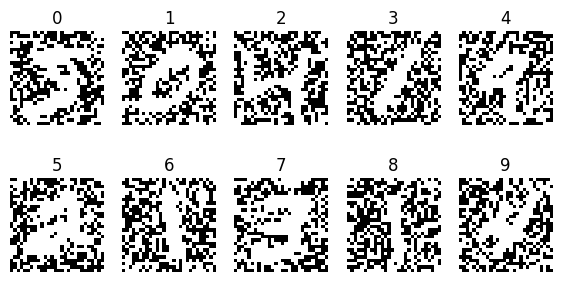

In [21]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = X_mnist_cover1[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [50]:
%%time
πs, zs, θs, Ms= gibbs_missing(X_mnist_cover1, 100, 25, 10)

CPU times: user 5min 53s, sys: 45 ms, total: 5min 53s
Wall time: 4min 34s


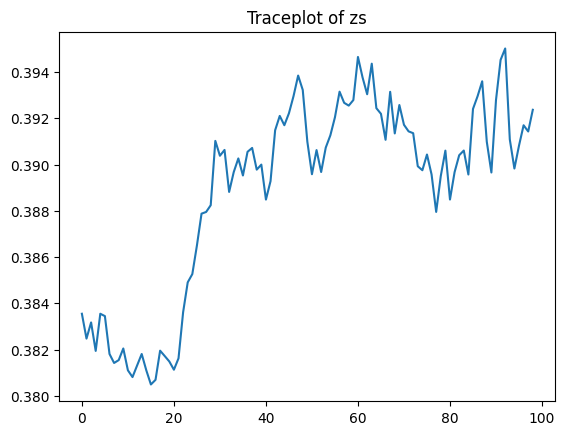

In [52]:
scores = [metrics.adjusted_rand_score(Y_mnist_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [53]:
metrics.adjusted_rand_score(Y_mnist_train, zs[-1])

0.3923671578868874

---

In [28]:
dirpath = "./../../Datasets/Bernoulli/Processed/MP2024/"
X = np.load(dirpath + "X_mp2024.npy")
y = np.load(dirpath + "y_mp2024.npy")

In [29]:
πs, zs, θs, Ms= gibbs_missing(X, 1000, 250, 9)

In [26]:
from scipy.stats import mode
z_ref = mode(zs, axis=0).mode.squeeze()

In [30]:
metrics.adjusted_rand_score(zs[-1],y)

0.4701337758137726

---

In [31]:
dirpath_synthetic = "./../../Datasets/Bernoulli/Processed/synthetic/"

X_train_synthetic = np.load(dirpath_synthetic + "X_train_synthetic.npy")
y_train_synthetic = np.load(dirpath_synthetic + "y_train_synthetic.npy")
X_test_synthetic = np.load(dirpath_synthetic + "X_test_synthetic.npy")
y_test_synthetic = np.load(dirpath_synthetic + "y_test_synthetic.npy")
means = np.load(dirpath_synthetic + "means_synthetic.npy")

In [35]:
def generate_mnar_mixture_data(X, y, K):
    N,D = X.shape
    
    # Step 4: Missingness mechanism — per-cluster missingness probability
    γ = rng.uniform(0.4, 0.9, size=(K, D))  # Lower = more missing

    R = np.ones((N, D), dtype=bool)  # missingness mask: True = observed

    for n in range(N):
        k = y[n]

        # Sample missingness
        R[n] = rng.binomial(1, 1 - γ[k])  # 1 = observed

    X_missing = X.copy().astype(np.float64).copy()
    X_missing[~R] = np.nan  # Mask out missing entries

    return X_missing


In [36]:
X_missing = generate_mnar_mixture_data(X_train_synthetic, y_train_synthetic, 10)

In [37]:
πs, zs, θs, Ms= gibbs_missing(X_train_synthetic, 1000, 250, 10)

In [38]:
metrics.adjusted_rand_score(y_train_synthetic, zs[-1])

0.5522190323988085

In [44]:
πs, zs, θs, Ms= gibbs_missing(X_train_synthetic, 1000, 250, 10, mnar=False)

In [45]:
metrics.adjusted_rand_score(y_train_synthetic, zs[-1])

0.6059268092684745